# Project Description

This is an animal classification project we have created to classify various animals into different categories.We have used the Animals-10 dataset on Kaggle to perform this task.


# Importing necessary libararies

* numpy - NumPy is a library for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

* pandas - Pandas is a software library for data manipulation and analysis.

* keras - Keras is an open-source library that provides a Python interface for artificial neural networks. We will use to implement the model.

* matplotlib - Matplotlib is a plotting library used for plotting various charts and graphs to better understand the data and progress of our model.

* sklearn - Sci-kit Learn is a library with various functionalities that ease several data handling and feature preprocessing tasks.









In [1]:
#Necessary imports
import numpy as np
import pandas as pd
import os

#For Preprocessing
import cv2
import itertools
from tqdm import tqdm_notebook as tqdm

#Additional imports for functionality
from sklearn.utils import class_weight, shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#For Graphing and Plotting Images
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline

#For model building
from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

ModuleNotFoundError: No module named 'keras'

# Exploring the data
Here we will get the data from the main Animals 10 Dataset. The Data is divided into 10 folder categories with one folder for each type of animasl. The animals that are present in this dataset are:

1. Dog
2. Squirrel
3. Horse 
4. Elephant
5. Butterfly
6. Chicken
7. Cat
8. Cow
9. Sheep
10. Spider

We will get the folders from the dataset and create a list of categories. As we go through the foldernames, we will append each of them to the categories list to keep track of them. In a files list, we will store all the images from the dataset as train_df. This will be used for training the model. 
We then take a loot at the data with train_df.head().



In [2]:
#Getting foldernames from dataset
foldernames = os.listdir('../input/animals10/raw-img')

#Creating Empty lists for categories and the files
categories = []
files = []
i = 0

#Going over all the folders and their categories in the foldernames
for k, folder in enumerate(foldernames):
    #Getting the filenames
    filenames = os.listdir("../input/animals10/raw-img/" + folder);
    for file in filenames:
        #Appending all the image files into one list
        files.append("../input/animals10/raw-img/" + folder + "/" + file)
        #Appending categories into one list
        categories.append(k)

#Defining a DataFrame to store data
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

#Taking 500 files of each category from the data into train_df
train_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

#Taking a peek at the data using head()
train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

,filename,category
0,../input/animals10/raw-img/scoiattolo/OIP-QbIO...,0
1,../input/animals10/raw-img/scoiattolo/OIP-ddMs...,0
2,../input/animals10/raw-img/scoiattolo/OIP-3Zp4...,0
3,../input/animals10/raw-img/scoiattolo/OIP-C1k6...,0
4,../input/animals10/raw-img/scoiattolo/OIP-3v3U...,0
...,...,...
4995,../input/animals10/raw-img/farfalla/OIP-maSaOv...,9
4996,../input/animals10/raw-img/farfalla/OIP-kccYzu...,9
4997,../input/animals10/raw-img/farfalla/OIP-yn99HU...,9
4998,../input/animals10/raw-img/farfalla/OIP-AbT7F0...,9


Here we can see we have 5000 total images numbered from 0 -4999. All the filenames are listed along with their respective categories.

# Data Preprocessing

We shuffle train_df to randomly distribute the images along with their categories.

In [3]:
#Assigning x and y to be the values and their target labels respectively
y = train_df['category']
x = train_df['filename']

#Shuffling to uniformly randomize the data
x, y = shuffle(x, y, random_state=8)

We perform image preprocessing using OpenCV to resize all the images and center them to make sure all data looks uniform.

In [25]:
#Standard DataPreprocessing from OpenCV used for formatting the input to fit 
#the specifications of the input of the VGG-16 model

def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    #Centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []
#tqdm is used for visualing the progress of the image preprocessing as a progress bar
with tqdm(total=len(train_df)) as pbar:
    #Going over all the filenames in train_df
    for i, file_path in enumerate(train_df.filename.values):
        #Read image using imread
        img = cv2.imread(file_path)
        #Converting colour channels of all pictures to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #Centering all the images
        img = centering_image(cv2.resize(img, dsize=(256, 256)))

        #We have to shape the output to 224x224px because the VGG-16 model takes in input shape of 224x224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

Now we take a look at few of the examples from the dataset.

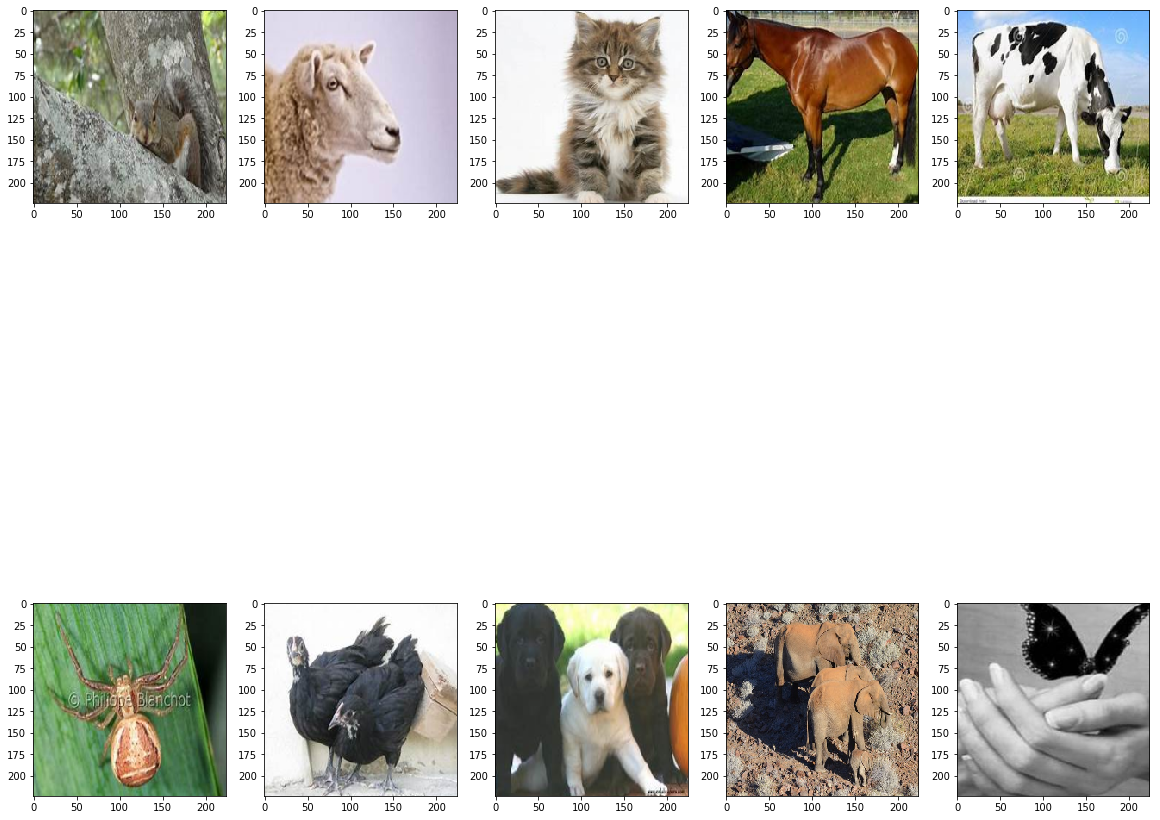

In [5]:
#10 images one for each category
rows,cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))

#Going over each category
for i in range(10):
    #Getting path for each category
    path = train_df[train_df.category == i].values[2]
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

Splitting the data into train and test sets. Train sets will be used to train and build the model and then we wil use the test set for model to evaluation to see how accurate our model is.

In [27]:
print(len(y))
data_num = len(y)
random_index = np.random.permutation(data_num)
print(random_index)

5000
[4979 3263  386 ... 3185 2778 4068]


In [6]:
#Getting a list of the number of images used and a random index permutation from the data
#to randomly append images into x_shuffle along with their labels
data_num = len(y)
random_index = np.random.permutation(data_num)

#Empty lists to store shuffled data
x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

#Partitioning 20% of the dataset into test set
test_split_num = int(round(0.2*len(y)))
x_train = x[test_split_num:]
y_train = y[test_split_num:]
x_test = x[:test_split_num]
y_test = y[:test_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

#Converting categories into binary matrix of 0s and 1s where 1 represents the correct class
#and 0s in all other places
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#Converting all pixel values to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Formatting all the pixel values to be in between 0 and 1
x_train /= 255
x_test /= 255

#Changing category labels from given language into english
img_rows, img_cols, img_channel = 224, 224, 3
name_animal = []
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'scoiattolo':
        name_animal.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        name_animal.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        name_animal.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        name_animal.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        name_animal.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        name_animal.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        name_animal.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        name_animal.append('dog')

x_train (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)


# Model Selection
We will be using a pretrained VGG-16 model trained on the Imagenet Dataset. All the paramteres except for those on the top layer will be freezed so that we can effectively use transfer learning on our task on Animal Classification. The Sequential Model of Keras is used in which we can add layers as we need. Two Dense layers have been added to the top, a layer with 256 neurons that uses a relu activation function and finally a layer with 10 output neurons and a softmax function is used to classify the images into one of the ten categories that we have.

In [7]:
#Getting the base VGG-16 model
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

#Sequential model used for the task
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(10, activation='softmax'))

#Defining the model
model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

The above is a summary of all the layers in the VGG-16 model.

# Model Fitting

We declare the batch size, i.e. the number of training images from the data thath we will be using to measure the loss of the model and perform gradient descent, for training the model and also the number of epochs, i.e. the number of times the entire datatset will be run throguh the model.

ImageDataGenerator is used to do Data Augmentation, i.e. slightly change tha data in certain ways such as to rotate it horizontally/ vertically, horiontally/vertically shift the image by a few pixels, flip the image horiontally, apply various filters and masks which change the pixel values of the original picture. This is very helpful for creating more data from a given small dataset and can be used to increase the size of the data so that the model can learn from more examples and give us a more effectiv estimation accuracy and decreased loss.

FitGenerator is used to fit and describe the model, to specify the data that will be used to train the model(X_train and y_train), how much of the batch size to use per step, how many epochs to run the entire data for. We have also added a Keras CallBack feature which keeps checkpoints of the model and updates after a certain time, so that if something goes wrong with the model we can revert it back to a point where it was still properly functional.

In [9]:
batch_size = 32
epochs = 65

#Data Augmentation
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)

#Fitting the model
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')]
)

Epoch 1/65
125/125 [==============================] - 54s 436ms/step - loss: 0.3256 - accuracy: 0.9000 - val_loss: 0.3156 - val_accuracy: 0.9000
Epoch 2/65
125/125 [==============================] - 53s 421ms/step - loss: 0.3083 - accuracy: 0.9000 - val_loss: 0.3019 - val_accuracy: 0.9000
Epoch 3/65
125/125 [==============================] - 53s 420ms/step - loss: 0.2924 - accuracy: 0.9001 - val_loss: 0.2833 - val_accuracy: 0.9006
Epoch 4/65
125/125 [==============================] - 52s 415ms/step - loss: 0.2730 - accuracy: 0.9021 - val_loss: 0.2582 - val_accuracy: 0.9063
Epoch 5/65
125/125 [==============================] - 53s 424ms/step - loss: 0.2454 - accuracy: 0.9089 - val_loss: 0.2281 - val_accuracy: 0.9170
Epoch 6/65
125/125 [==============================] - 53s 423ms/step - loss: 0.2175 - accuracy: 0.9181 - val_loss: 0.2039 - val_accuracy: 0.9245
Epoch 7/65
125/125 [==============================] - 52s 417ms/step - loss: 0.1972 - accuracy: 0.9258 - val_loss: 0.1835 - val_ac

We have managed to achieve an accuracy of 97% using this model!

Below we take a look at some metric graphs of validation loss vs training loss as well as validation accuracy vs training accuracy.

CNN: Epochs=65, Train accuracy=0.99278, Validation accuracy=0.97720


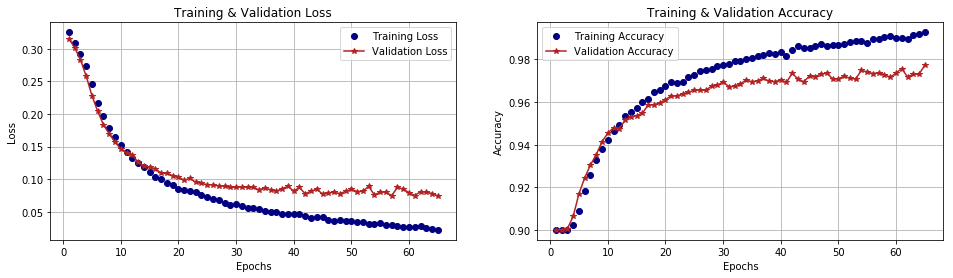

In [10]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))

#Function to plot Graphs
def show_plots(history):
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    #Plotting Graph for the Losses
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    #Plot Graph for the Accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    #Delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
    
show_plots(history.history)

# Confusion Matrix

We will be taking a look at the confusion matrix to get a deeper insight into our model.

In [11]:
#Getting test labels and predictions
preds = np.round(model.predict(x_test),0)  
categorical_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [32]:
#Function to Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Normalize the values
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Confusion matrix')
    
    #Plot the matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    #Going over all ten categories, and for each category going over all 
    #ten categories to get a square matrix for every category 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix


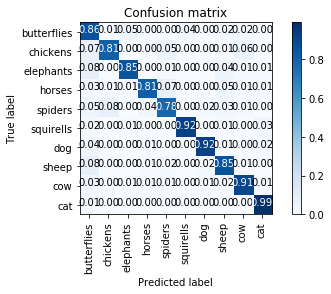

In [33]:
#Call plotting function
plot_confusion_matrix(confusion_matrix, 
                      ['butterflies', 'chickens', 'elephants', 'horses', 'spiders',
                       'squirells', 'dog', 'sheep', 'cow', 'cat'])

# Testing Images

We now check our models predictions on some test images.

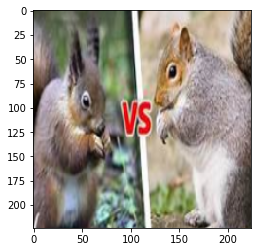

Actual  : squirrel
Predict : chicken


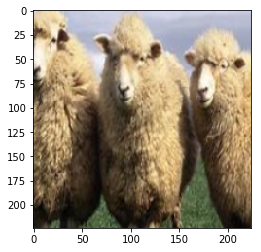

Actual  : sheep
Predict : chicken


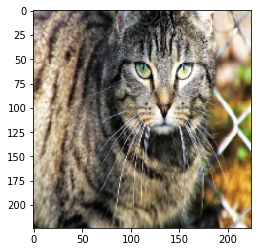

Actual  : cat
Predict : cat


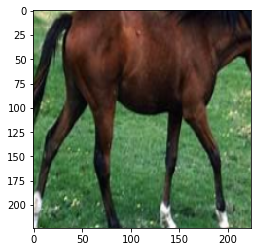

Actual  : horse
Predict : horse


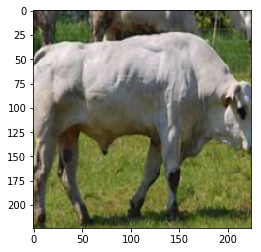

Actual  : cow
Predict : cow


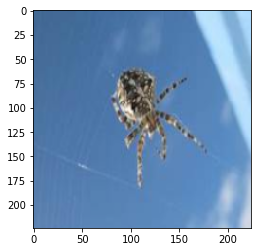

Actual  : spider
Predict : butterfly


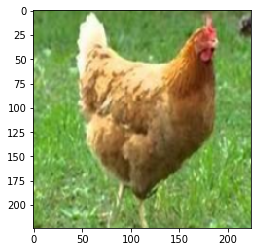

Actual  : chicken
Predict : chicken


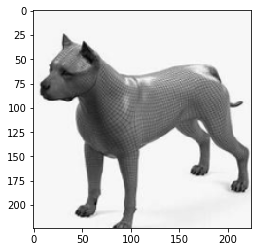

Actual  : dog
Predict : horse


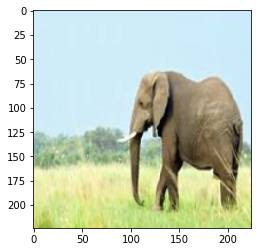

Actual  : elephant
Predict : elephant


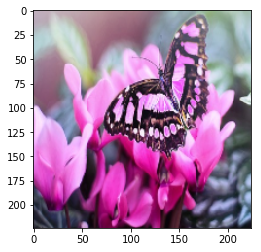

Actual  : butterfly
Predict : butterfly


In [14]:
#Empty list to get images for testing
test_images = []
j = 6

#Getting one image from each category for testing
for i in range(10):
    #Getting File Path
    path = train_df[train_df.category == i].values[j]
    #Getting Image from File
    a = images[train_df[train_df.filename == path[0]].index[0]]
    #Converting image into pixel array
    img = np.array(a)
    
    #Preprocessing images using opencv
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = centering_image(cv2.resize(img, dsize=(256, 256)))
    
    #Reshaping into 224x224psx for VGG-16 model 
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,224,224,3)

#Making predictions on test_images
predictions = model.predict(test_images)
animals = name_animal

#Plotting predictions
i = 0
for pred in predictions:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    i += 1


# Conclusion

After studying various outputs, we have seen that the model tends to be weak at ditinguishing between the categories when the colours of the animals tend to match colours more common to specific species, such as white dogs and cats being classified as sheep. This can possibly be solved with acquiring more data,
tweaking the hyperparameters such as using a deeper network or more neurons per layer, etc.

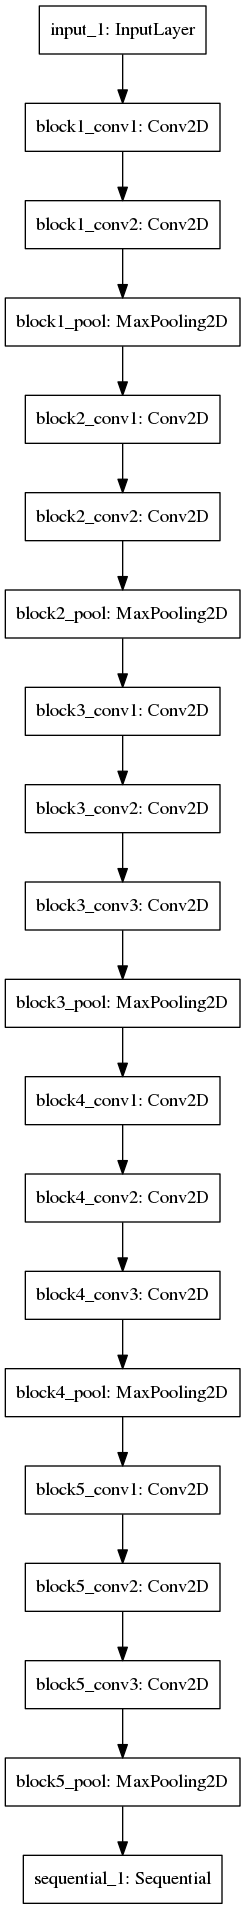

In [37]:
#Plotting model as png
from keras.utils import plot_model
plot_model(model, to_file='model.png')